# Floquet Solvers

Author: C. Staufenbiel, 2022

### Introduction

The *Floquet formalism* deals with periodic time-dependent systems. The Floquet approach can be more efficient for such problems than using the standard master equation solver `qutip.mesolve()` and it has a broader range of validity for periodic driving.

In this notebook, we will discuss the solver functionality of the Floquet formalism implemented in QuTiP using an example quantum system. A more detailed introduction into the Floquet formalism can be found in the [documentation](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-floquet.html).

A more in depth introduction into the internal functions of the Floquet formalism, used also by the solvers `fsesolve` and `fmmesolve`, is given in the [*floquet formalism notebook*](012_floquet_formalism.md).

### Imports

In [1]:
import numpy as np
from qutip import (about, basis, fmmesolve, fsesolve,
                   plot_expectation_values, sigmax, sigmaz)

In this example we will consider a strongly driven two level system, described by the time-dependent Hamiltonian:

$$ H(t) = -\frac{\Delta}{2} \sigma_x - \frac{\epsilon_0}{2} \sigma_z + \frac{A}{2} sin(\omega t) \sigma_z$$

In [2]:
# define constants
delta = 0.2 * 2 * np.pi
eps0 = 2 * np.pi
A = 2.5 * 2 * np.pi
omega = 2 * np.pi

# Non driving hamiltoninan
H0 = -delta / 2.0 * sigmax() - eps0 / 2.0 * sigmaz()

# Driving Hamiltonian
H1 = [A / 2.0 * sigmaz(), "sin(w*t)"]
args = {"w": omega}

# combined hamiltonian
H = [H0, H1]

# initial state
psi0 = basis(2, 0)

### Floquet Schrödinger Equation

We can now use the `qutip.fsesolve()` function to solve the dynamics of the system using the Floquet formalism for the Schrödinger equation. The arguments are similar to the ones passed to `qutip.sesolve()`. There is an optional parameter `T` which defines the period of the time-dependence. If `T` is not given it is assumed that the passed `tlist` spans one period. Therefore we always pass `T` in this tutorial.

/usr/share/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/coefficient.py:420: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


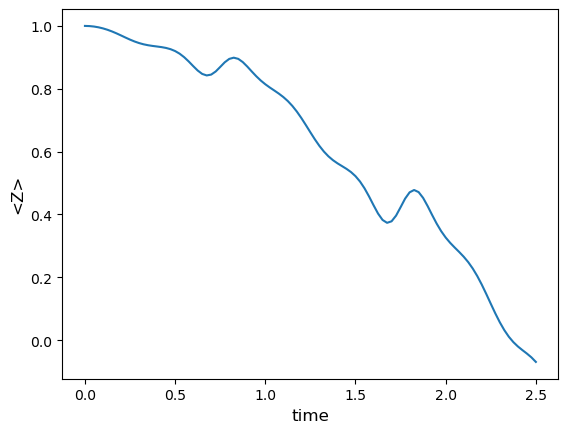

In [3]:
# period time
T = 2 * np.pi / omega
# simulation time
tlist = np.linspace(0, 2.5 * T, 101)
# simulation
result = fsesolve(H, psi0, tlist, T=T, e_ops=[sigmaz()], args=args)

plot_expectation_values([result], ylabels=["<Z>"]);

### Floquet Markov Master Equation

Similar to `mesolve()` we can also use the Floquet formalism to solve a master equation  for a dissipative quantum system. The corresponding function is `fmmesolve()`. However, the dissipation process is here described as a noise spectral-density function.

For example we can define a linear noise spectral-density as:

$$ S(\omega) = \frac{\gamma \cdot \omega}{4 \pi} $$

where $\gamma$ is the dissipation rate. The system-bath interaction is described by coupling operators, e.g. here we use $\sigma_x$ as a coupling operator.

Each spectral function callable should accept a numpy array of frequencies and return an array of spectral densities. The frequencies passed in correspond to differences in the Floque quasi-energies and may be negative. One can return zero power for negative frequencies by multiplying the spectral density function by `(omega > 0)`, as   we do in the code below.

In [4]:
# Noise Spectral Density
gamma = 0.5


def noise_spectrum(omega):
    return (omega > 0) * gamma * omega / (4 * np.pi)


# Coupling operator and noise spectrum
c_ops = [sigmax()]
spectra_cb = [noise_spectrum]

# Solve using Fmmesolve
fme_result = fmmesolve(
    H,
    psi0,
    tlist,
    c_ops=c_ops,
    spectra_cb=spectra_cb,
    e_ops=[sigmaz()],
    T=T,
    args=args,
)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00


20.0%. Run time:   0.00s. Est. time left: 00:00:00:00


30.0%. Run time:   0.01s. Est. time left: 00:00:00:00


40.0%. Run time:   0.01s. Est. time left: 00:00:00:00


50.0%. Run time:   0.01s. Est. time left: 00:00:00:00


60.0%. Run time:   0.01s. Est. time left: 00:00:00:00


70.0%. Run time:   0.01s. Est. time left: 00:00:00:00


80.0%. Run time:   0.02s. Est. time left: 00:00:00:00


90.0%. Run time:   0.02s. Est. time left: 00:00:00:00


100.0%. Run time:   0.02s. Est. time left: 00:00:00:00


Total run time:   0.02s


We can observe the dissipation dynamics when comparing the results to the expectation values obtained from `fsesolve()`.

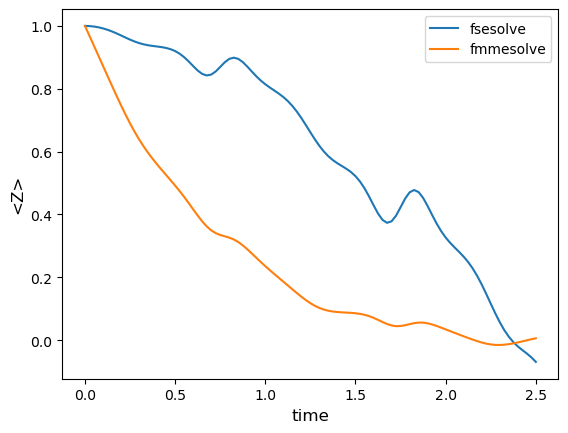

In [5]:
fig, axes = plot_expectation_values([result, fme_result], ylabels=["<Z>"])
axes[0].legend(['fsesolve', 'fmmesolve'], loc='upper right');

### About

In [6]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+c5761bb
Numpy Version:      2.2.1
Scipy Version:      1.14.1
Cython Version:     3.0.11
Matplotlib Version: 3.10.0
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /usr/share/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a 

### Testing

In [7]:
fme_result_nodis = fmmesolve(
    H,
    psi0,
    tlist,
    c_ops=c_ops,
    spectra_cb=[lambda w: np.zeros_like(w)],
    e_ops=[sigmaz()],
    T=T,
    args=args,
)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00


20.0%. Run time:   0.00s. Est. time left: 00:00:00:00


30.0%. Run time:   0.00s. Est. time left: 00:00:00:00


40.0%. Run time:   0.01s. Est. time left: 00:00:00:00


50.0%. Run time:   0.01s. Est. time left: 00:00:00:00


60.0%. Run time:   0.01s. Est. time left: 00:00:00:00


70.0%. Run time:   0.01s. Est. time left: 00:00:00:00


80.0%. Run time:   0.01s. Est. time left: 00:00:00:00


90.0%. Run time:   0.02s. Est. time left: 00:00:00:00


100.0%. Run time:   0.02s. Est. time left: 00:00:00:00


Total run time:   0.02s


In [8]:
assert np.allclose(result.expect[0], fme_result_nodis.expect[0], atol=0.1)
assert not np.allclose(fme_result.expect[0],
                       fme_result_nodis.expect[0], atol=0.1)